### Numerical tests of the methods proposed in
### "Structure preserving discretization of time-reparameterized Hamiltonian systems with application to nonholonomic mechanics"
### by Luis García Naranjo and Mats Vermeeren.

In [26]:
### Import tools and settings

import numpy as np
import sympy as sp

from scipy.integrate import solve_ivp
import scipy.optimize as so

from scipy.spatial import ConvexHull

import multiprocessing as multip

# Modified quantities (Calculated in SageMath)
from modified_quantities import kmod, emod, mod_N

# Plot tools and settings
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'legend.columnspacing': 5,
          'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'text.usetex': 'True'}
pylab.rcParams.update(params)

In [33]:
### Returns the integrator corresponding to a given discrete Lagrangian.

def dEL(lag, tol=1e-08):
    px,py,x0,x1,y0,y1,h = sp.symbols("px py x0 x1 y0 y1 h")
    px0 = sp.expand( - h * sp.diff(lag(x0,x1,y0,y1,h),x0) )
    px1 = sp.expand( h * sp.diff(lag(x0,x1,y0,y1,h),x1) )
    py0 = sp.expand( - h * sp.diff(lag(x0,x1,y0,y1,h),y0) )
    py1 = sp.expand( h * sp.diff(lag(x0,x1,y0,y1,h),y1) )
    
    equation = sp.lambdify([px,x0,x1,py,y0,y1,h], [px0 - px, py0 - py])
        
    peq = sp.lambdify([x0,x1,y0,y1,h],[px1,py1])

    def integrator(init, tspan, h):
        t0, t1 = tspan
        steps = int(np.floor((t1-t0)/h))

        sol = np.empty([steps+1, 4], dtype=np.float64)
        sol[0] = np.array(init)
        for i in range(steps):
            px, x, py, y = sol[i]
            [xnew,ynew] = so.fsolve(lambda new: equation(px,x,new[0],py,y,new[1],h), [x,y], xtol=tol)
            [pxnew,pynew] = peq(x,xnew,y,ynew,h)
            sol[i+1] = np.array((pxnew, xnew, pynew, ynew))
        return sol
    
    return integrator

## Solutions and energy ##
### Comparison between different integrators ###

In [36]:
### Compare the 5 proposed discretizations with a high-accuracy reference solution
#
# init: initial contdition (px, x, py, y)
# tspan: range of time (t_0,t_1)
# h: step size
# order (int): truncation order (highest order to include) of modified quantities
# potential (bool): Free nonholonomic particla if False, harmonic potential if True
# Ecorrection (bool): If False, uses leading order value of E instead of higher order.
# showE (bool): If False, plots error norm instead of energy.

def compare_integrators(init, tspan, h, order=4, potential=False, Ecorrection=True, showE=True):
    
    # Conformal factor
    N = lambda y: 1.0/sp.sqrt(1+y**2)
    
    # x-coordinates of plot points
    timerange = np.arange(tspan[0], tspan[1]+.00001, h)
    
    # reference solution
    if potential:
        def odes(t,v):
            px,x,py,y = v
            return [-x/np.sqrt(1+y**2), px/np.sqrt(1+y**2), -y*py**2/np.sqrt(1+y**2) - y/np.sqrt(1+y**2), py*np.sqrt(1+y**2)] #these are p-tilde variables
    else:
        def odes(t,v):
            px,x,py,y = v
            return [0, px/np.sqrt(1+y**2), -y*py**2/np.sqrt(1+y**2), py*np.sqrt(1+y**2)] #these are p-tilde variables
    sref = solve_ivp(odes, tspan, init, t_eval=timerange, rtol=1e-8, atol=1e-8)
    sref = np.transpose(sref.y)
    
    # Construct Hamiltonians
    if potential:
        U = lambda x,y: .5 * x**2 + .5 * y**2
    else:
        U = lambda x,y: 0
    ham = lambda px,x,py,y: 1/2*py**2*(1+y**2) + 1/2*px**2 + U(x,y)
    aham = lambda px,x,py,y,E: N(y)*(ham(px,x,py,y)-E)
    
    # Modified conformal Hamiltonians 
    emod1 = emod(order, "M", h, potential)
    emod2 = emod(order, "TM", h, potential)
    emod3 = emod(order, "MT", h, potential)
    emod4 = emod(order, "TT", h, potential)
    emod5 = emod(order, "T", h, potential)
    
    Ed0 = ham(*init)
    if Ecorrection:
        Ed1 = emod1(*init)
        Ed2 = emod2(*init)
        Ed3 = emod3(*init)
        Ed4 = emod4(*init)
        Ed5 = emod5(*init)
    else:
        Ed1 = Ed2 = Ed3 = Ed4 = Ed5 = Ed0
    
    # Modified altered Hamiltonians
    k = lambda px,x,py,y: aham(px,x,py,y,Ed0)
    kmod1 = kmod(order, "M", h, Ed1, potential)
    kmod2 = kmod(order, "TM", h, Ed2, potential)
    kmod3 = kmod(order, "MT", h, Ed3, potential)
    kmod4 = kmod(order, "TT", h, Ed4, potential)
    kmod5 = kmod(order, "T", h, Ed5, potential)
    

    # Discrete altered Lagrangians
    def N(y):
        return 1/sp.sqrt(1+y**2)
    if potential:
        def L(x,y,vx,vy):
            return 1/2*(1+y**2)*vx**2 + 1/2*vy**2 - 1/2*x**2 - 1/2*y**2
    else:
        def L(x,y,vx,vy):
            return 1/2*(1+y**2)*vx**2 + 1/2*vy**2
    def LdiscMM(x0,x1,y0,y1,h):
        return N( (y0+y1)/2 ) * ( L( (x0+x1)/2, (y0+y1)/2, (x1-x0)/h, (y1-y0)/h ) + Ed1 )
    def LdiscTM(x0,x1,y0,y1,h):
        return (N(y0)+N(y1))/2 * ( L( (x0+x1)/2, (y0+y1)/2, (x1-x0)/h, (y1-y0)/h ) + Ed2 )
    def LdiscMT(x0,x1,y0,y1,h):
        return N( (y0+y1)/2 ) * ( L(x0, y0, (x1-x0)/h, (y1-y0)/h )/2 + L(x1, y1, (x1-x0)/h, (y1-y0)/h )/2 + Ed3 )
    def LdiscTT(x0,x1,y0,y1,h):
        return (N(y0)+N(y1))/2 * ( L(x0, y0, (x1-x0)/h, (y1-y0)/h )/2 + L(x1, y1, (x1-x0)/h, (y1-y0)/h )/2 + Ed4 )
    def LdiscT(x0,x1,y0,y1,h):
        return N(y0)*(L(x0, y0, (x1-x0)/h, (y1-y0)/h ) + Ed5)/2 + N(y1)*(L(x1, y1, (x1-x0)/h, (y1-y0)/h ) + Ed5)/2

    # Variational integrators
    integrator1 = dEL(LdiscMM)
    integrator2 = dEL(LdiscTM)
    integrator3 = dEL(LdiscMT)
    integrator4 = dEL(LdiscTT)
    integrator5 = dEL(LdiscT)
    acc = [lambda px,x,py,y,k=k: odes(0,[px,x,py,y])[k] for k in range(4)]

    # Solution
    s1 = integrator1(init,tspan,h) #px, x, py, y
    s2 = integrator2(init,tspan,h) #px, x, py, y
    s3 = integrator3(init,tspan,h) #px, x, py, y
    s4 = integrator4(init,tspan,h) #px, x, py, y
    s5 = integrator5(init,tspan,h) #px, x, py, y
    
    # define plots   
    plt.figure(figsize=(16,10))
    
    plt.subplot(221)
    plt.title("Original Hamiltonian $H$")
    N4 = lambda px,x,py,y: N(y) 
    plt.plot(timerange, list(map(lambda l: ham(*l),s1)), label="M", linestyle="-", marker="o", markevery=[i for i in range(1,int((tspan[1]-tspan[0])/h),6)])
    plt.plot(timerange, list(map(lambda l: ham(*l),s3)), label="MT", linestyle="-", marker="v", markevery=[i for i in range(2,int((tspan[1]-tspan[0])/h),6)])
    plt.plot(timerange, list(map(lambda l: ham(*l),s2)), label="TM", linestyle="-", marker="s", markevery=[i for i in range(3,int((tspan[1]-tspan[0])/h),6)])
    plt.plot(timerange, list(map(lambda l: ham(*l),s4)), label="TT", linestyle="-", marker="^", markevery=[i for i in range(4,int((tspan[1]-tspan[0])/h),6)])
    plt.plot(timerange, list(map(lambda l: ham(*l),s5)), label="T", linestyle="-", marker="d", markevery=[i for i in range(5,int((tspan[1]-tspan[0])/h),6)])
    plt.grid()
    
    plt.subplot(222)
    plt.title("Altered Hamiltonian $K$")
    plt.plot(timerange, list(map(lambda l: k(*l),s1)), label="M", linestyle="-", marker="o", markevery=[i for i in range(1,int((tspan[1]-tspan[0])/h),6)])
    plt.plot(timerange, list(map(lambda l: k(*l),s3)), label="MT", linestyle="-", marker="v", markevery=[i for i in range(2,int((tspan[1]-tspan[0])/h),6)])
    plt.plot(timerange, list(map(lambda l: k(*l),s2)), label="TM", linestyle="-", marker="s", markevery=[i for i in range(3,int((tspan[1]-tspan[0])/h),6)])
    plt.plot(timerange, list(map(lambda l: k(*l),s4)), label="TT", linestyle="-", marker="^", markevery=[i for i in range(4,int((tspan[1]-tspan[0])/h),6)])
    plt.plot(timerange, list(map(lambda l: k(*l),s5)), label="T", linestyle="-", marker="d", markevery=[i for i in range(5,int((tspan[1]-tspan[0])/h),6)])
    plt.grid()
    
    plt.subplot(223)
    plt.title("Modified altered Hamiltonian $K_{mod}$")
    plt.plot(timerange, list(map(lambda l: kmod1(*l),s1)), label="M", linestyle="-", marker="o", markevery=[i for i in range(1,int((tspan[1]-tspan[0])/h),6)])
    plt.plot(timerange, list(map(lambda l: kmod3(*l),s3)), label="MT", linestyle="-", marker="v", markevery=[i for i in range(2,int((tspan[1]-tspan[0])/h),6)])
    plt.plot(timerange, list(map(lambda l: kmod2(*l),s2)), label="TM", linestyle="-", marker="s", markevery=[i for i in range(3,int((tspan[1]-tspan[0])/h),6)])
    plt.plot(timerange, list(map(lambda l: kmod4(*l),s4)), label="TT", linestyle="-", marker="^", markevery=[i for i in range(4,int((tspan[1]-tspan[0])/h),6)])
    plt.plot(timerange, list(map(lambda l: kmod5(*l),s5)), label="T", linestyle="-", marker="d", markevery=[i for i in range(5,int((tspan[1]-tspan[0])/h),6)])
    plt.grid()
    
    plt.subplot(224)
    if showE:
        plt.title("Modified conformal Hamiltonian $\mathcal{E}$")
        plt.plot(timerange, list(map(lambda l: emod1(*l),s1)), label="M", linestyle="-", marker="o", markevery=[i for i in range(1,int((tspan[1]-tspan[0])/h),6)])
        plt.plot(timerange, list(map(lambda l: emod3(*l),s3)), label="MT", linestyle="-", marker="v", markevery=[i for i in range(2,int((tspan[1]-tspan[0])/h),6)])
        plt.plot(timerange, list(map(lambda l: emod2(*l),s2)), label="TM", linestyle="-", marker="s", markevery=[i for i in range(3,int((tspan[1]-tspan[0])/h),6)])
        plt.plot(timerange, list(map(lambda l: emod4(*l),s4)), label="TT", linestyle="-", marker="^", markevery=[i for i in range(4,int((tspan[1]-tspan[0])/h),6)])
        plt.plot(timerange, list(map(lambda l: emod5(*l),s5)), label="T", linestyle="-", marker="d", markevery=[i for i in range(5,int((tspan[1]-tspan[0])/h),6)])
        plt.grid()
    
    else:
        plt.title("Error norm")
        plt.plot(timerange, list(map(np.linalg.norm,s1-sref)), label="M", linestyle="-", marker="o", markevery=[i for i in range(1,int((tspan[1]-tspan[0])/h),6)])
        plt.plot(timerange, list(map(np.linalg.norm,s3-sref)), label="MT", linestyle="-", marker="v", markevery=[i for i in range(2,int((tspan[1]-tspan[0])/h),6)])
        plt.plot(timerange, list(map(np.linalg.norm,s2-sref)), label="TM", linestyle="-", marker="s", markevery=[i for i in range(3,int((tspan[1]-tspan[0])/h),6)])
        plt.plot(timerange, list(map(np.linalg.norm,s4-sref)), label="TT", linestyle="-", marker="^", markevery=[i for i in range(4,int((tspan[1]-tspan[0])/h),6)])
        plt.plot(timerange, list(map(np.linalg.norm,s5-sref)), label="T", linestyle="-", marker="d", markevery=[i for i in range(5,int((tspan[1]-tspan[0])/h),6)])
        plt.grid()
    plt.legend(loc='lower left', bbox_to_anchor=(-1.0, -.3), fancybox=True, shadow=True, ncol=5)

    plt.rc('text', usetex=True)
    plt.show()

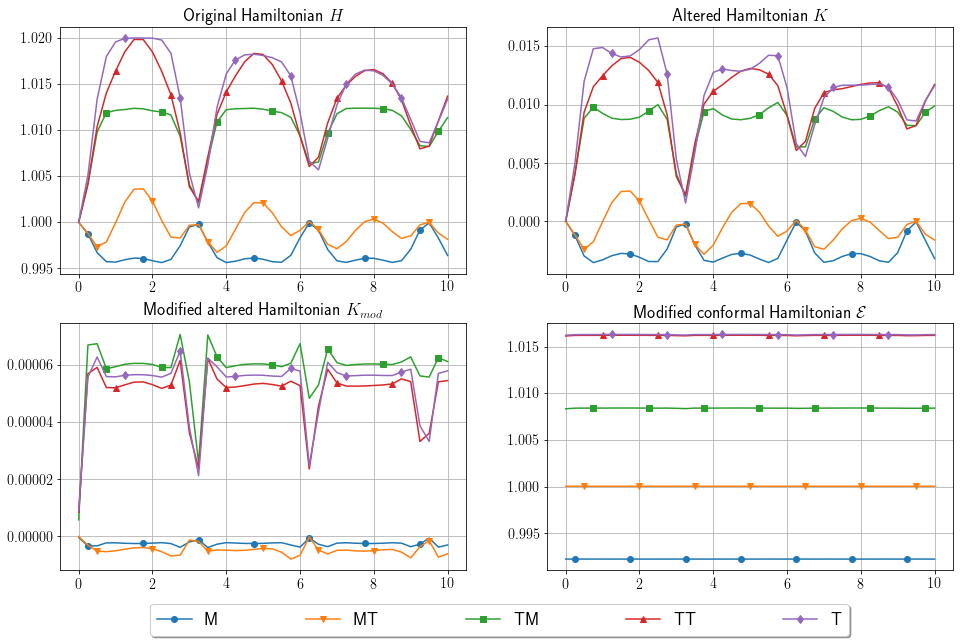

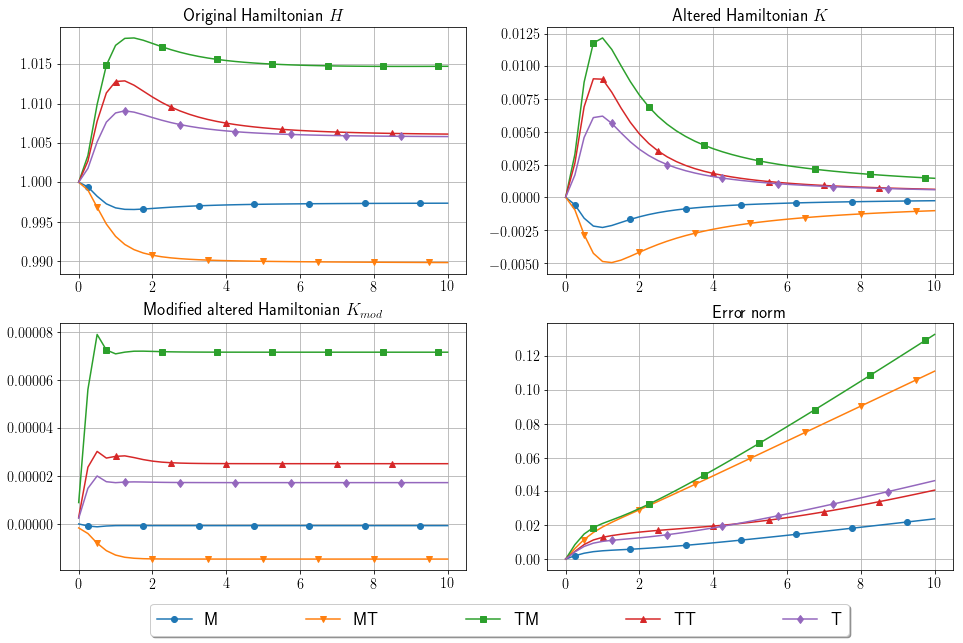

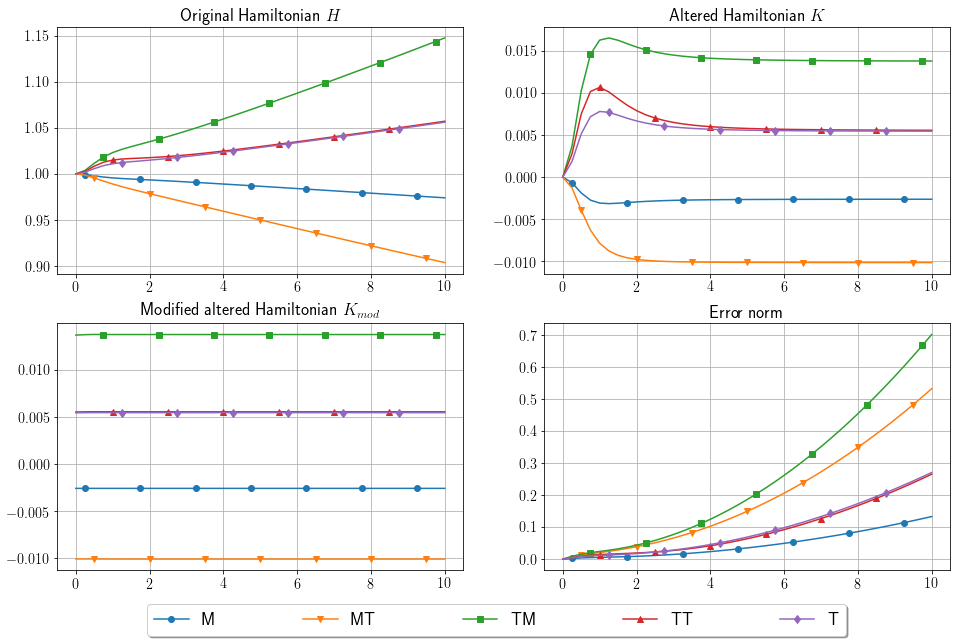

In [35]:
init = (1.0, 0.0, 1.0, 0.0) #px, x, py, y
tspan = (0.0, 10.0)
h = 0.25

# Fig 5.3
compare_integrators(init, tspan, h, order=4, potential=True, Ecorrection=True)

# Fig 5.5
compare_integrators(init, tspan, h, order=4, potential=False, Ecorrection=True, showE=False)

# Fig 5.6
compare_integrators(init, tspan, h, order=4, potential=False, Ecorrection=False, showE=False)

## Measure preservation ##

In [37]:
### Track a volume of phase space approximated by a point cloud
#
# initlist: list of initial contditions on the edge of the volume
# tspan: range of time (t_0,t_1)
# h: step size
# method: label/name of the numerical method to use
# potential (bool): Free nonholonomic particla if False, harmonic potential if True
# Ecorrection (bool): If False, uses leading order value of E instead of higher order.

def simulate_point_cloud(initlist, tspan, h, method="M", potential=True, Ecorrection=True):
    # Conformal factor
    N = lambda y: 1.0/sp.sqrt(1+y**2)
    
    # x-coordinates of plot points
    timerange = np.arange(tspan[0], tspan[1]+.00001, h)
    
    # For reference solution
    if potential:
        def odes(t,v):
            px,x,py,y = v
            return [-x/np.sqrt(1+y**2), px/np.sqrt(1+y**2), -y*py**2/np.sqrt(1+y**2) - y/np.sqrt(1+y**2), py*np.sqrt(1+y**2)] #these are p-tilde variables
    else:
        def odes(t,v):
            px,x,py,y = v
            return [0, px/np.sqrt(1+y**2), -y*py**2/np.sqrt(1+y**2), py*np.sqrt(1+y**2)] #these are p-tilde variables
    
    # Construct Lagrangian and energy
    Kin = lambda x,y,dx,dy: .5 * (1 + y**2) * dx**2 + .5 * dy**2
    if potential:
        U = lambda x,y: .5 * x**2 + .5 * y**2
    else:
        U = lambda x,y: 0
    L = lambda x,y,dx,dy: Kin(x,y,dx,dy) - U(x,y)
    
    global track_cloud #avoid pickling error in parallel computation
    def track_cloud(init):
        if Ecorrection:
            Ed = emod(4, method, h, potential)(*init)
        else:
            Ed = emod(0, method, h, potential)(*init)
        
        def LfreediscM(x0,x1,y0,y1,h):
            return N( (y0+y1)/2 ) * ( L( (x0+x1)/2, (y0+y1)/2, (x1-x0)/h, (y1-y0)/h ) + Ed )
        def LfreediscTM(x0,x1,y0,y1,h):
            return (N(y0)+N(y1))/2 * ( L( (x0+x1)/2, (y0+y1)/2, (x1-x0)/h, (y1-y0)/h ) + Ed )
        def LfreediscMT(x0,x1,y0,y1,h):
            return N( (y0+y1)/2 ) * ( L(x0, y0, (x1-x0)/h, (y1-y0)/h )/2 + L(x1, y1, (x1-x0)/h, (y1-y0)/h )/2 + Ed )
        def LfreediscTT(x0,x1,y0,y1,h):
            return (N(y0)+N(y1))/2 * ( L(x0, y0, (x1-x0)/h, (y1-y0)/h )/2 + L(x1, y1, (x1-x0)/h, (y1-y0)/h )/2 + Ed )
        def LfreediscT(x0,x1,y0,y1,h):
            return N(y0)*(L(x0, y0, (x1-x0)/h, (y1-y0)/h ) + Ed)/2 + N(y1)*(L(x1, y1, (x1-x0)/h, (y1-y0)/h ) + Ed)/2

        if method == "M":
            integrator = dEL(LfreediscM)
        if method == "TM":
            integrator = dEL(LfreediscTM)
        if method == "MT":
            integrator = dEL(LfreediscMT)
        if method == "TT":
            integrator = dEL(LfreediscTT)
        if method == "T":
            integrator = dEL(LfreediscT)
        if method == "Reference":
            def integrator(init,tspan,h):
                sref = solve_ivp(odes, tspan, init, t_eval=timerange, rtol=1e-12, atol=1e-12)
                return np.transpose(sref.y)
        return integrator(init,tspan,h)
    
    trajectories = [track_cloud(initlist[0])]
    
    pool = multip.Pool(multip.cpu_count())
    
    trajectories += pool.map_async(track_cloud, initlist[1:]).get()
    cloudlist = np.transpose(trajectories, (1, 0, 2))
    
    pool.close()
    pool.join()
    
    return cloudlist

In [38]:
### Compute (approximate) measures of list of point clouds
#
# cloudlist: list of point clouds
# method: name/label of numerical method, to decide which modified measure to use
# h: step size
# potential (bool): Free nonholonomic particla if False, harmonic potential if True

def measures(cloudlist, method, h, potential):    
    measure_list = []
    for rescale in [0,2,4]:
        vol = []        
        for cloud in cloudlist:
            yscaling = lambda x: [x[0], x[1], x[2], 1/2 * (x[3] * np.sqrt(1 + x[3]**2) + np.arcsinh(x[3]))]
            ycloud = list(map(yscaling, cloud))
            
            factor = lambda x: 1/mod_N(rescale,method,h,potential)(*x) #/ np.sqrt(1 + x[3]**2)
            scaling1 = factor(cloud[0]) # scale factor at central point
            scaling2 = np.mean(list(map(factor, cloud[1:]))) # average scale factor on shell
            
            vol += [ (scaling1/3 + 2*scaling2/3) * ConvexHull(cloud).volume] # estimate of scale factor integral / volume, O(r^4)-error
            # \int_{B^4(r)} f = \pi^2/6 r^4 f(0) + \pi^2/3*r^4
            # vol(B^4(r)) = \pi^2 r^4 / 2
        measure_list += [vol]
    return measure_list

### Compare measure behavior of different methods
#
# initlist: list of points in initial point cloud
# tspan: range of time (t_0,t_1)
# h: step size
# methods: list of numerical methods to compare
# potential (bool): Free nonholonomic particla if False, harmonic potential if True
# Ecorrection (bool): If False, uses leading order value of E instead of higher order.

def compare_methods(initlist, tspan, h, methods, potential=True, Ecorrection=False):
    data = []
    for m in methods:
        print(m)
        cloudlist = simulate_point_cloud(initlist, tspan, h, method=m, potential=potential, Ecorrection=Ecorrection)
        data += [measures(cloudlist, m, h, potential)]
    data = np.transpose(data,(1,0,2))

    plt.figure(figsize=(16,10))
    plt.subplot(221) 
    plt.title("$\mu_{mod}^{(0)} = \mu$")
    k = 0
    markers = ["o","v","s","^","d",None]
    for data_method in data[0]:
        plt.plot(np.arange(tspan[0], tspan[1]+1e-12, h), data_method,label = methods[k], marker=markers[k], markevery=[i for i in range(3*k+10,int((tspan[1]-tspan[0])/h),25)]) 
        k += 1
    plt.grid()
    plt.subplot(222) 
    plt.title("$\mu_{mod}^{(2)}$")
    k = 0
    for data_method in data[1]:
        plt.plot(np.arange(tspan[0], tspan[1]+1e-12, h), data_method,label = methods[k], marker=markers[k], markevery=[i for i in range(3*k+10,int((tspan[1]-tspan[0])/h),25)]) 
        k += 1
    plt.grid()
    plt.subplot(223) 
    plt.title("$\mu_{mod}^{(4)}$")
    k = 0
    for data_method in data[2]:
        plt.plot(np.arange(tspan[0], tspan[1]+1e-12, h), data_method,label = methods[k], marker=markers[k], markevery=[i for i in range(3*k+10,int((tspan[1]-tspan[0])/h),25)]) 
        k += 1
    plt.grid()
    plt.legend(loc='lower left', bbox_to_anchor=(1.2, .2), fancybox=True, shadow=True, ncol=1)
    plt.show()

M
MT
TM
TT
T
Reference


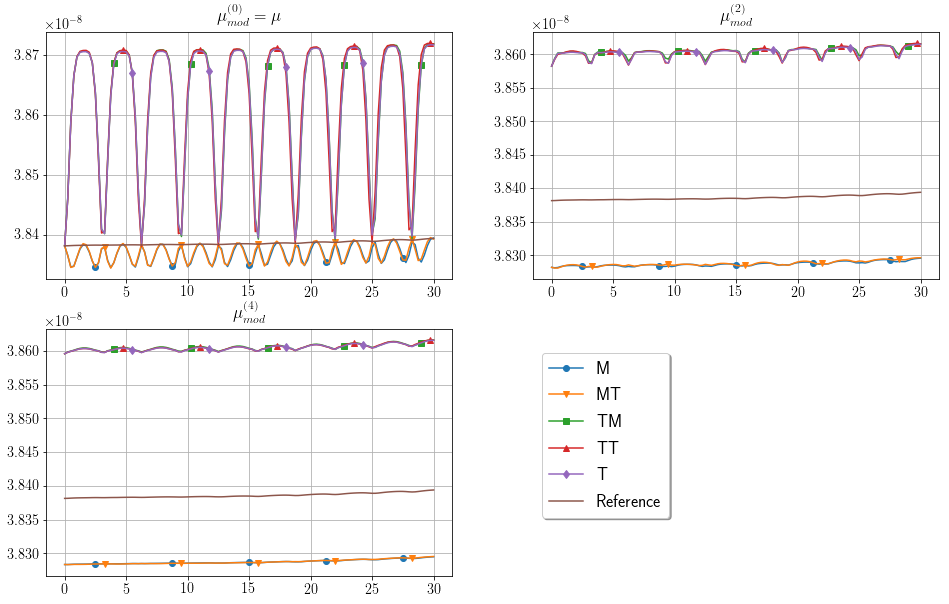

In [39]:
# Load points of a 600-cell (convex regular 4-polytope)
f = open("600cell.4.120.txt", "r")
sd = []
l = f.readline().split(" ")
l = list(filter(lambda a: a != "", l))
for i in range(120):
    l = f.readline().split(" ")
    l = list(filter(lambda a: a != "", l))
    sd += [ [float(x) for x in l] ]
sd = sd[:-1]

# Center and radius of point cloud
center = [1,0,1,0]
r = 0.01

# Translate and rescale 600-cell
tspan = (0.0, 30.0)
initlist = [center]
for v in sd:
    initlist += [ np.add(center, np.multiply(r,v) ) ]

# Step size
h = .25

# Fig 5.2
compare_methods(initlist, tspan, h, ["M","MT","TM","TT","T","Reference"], potential=True, Ecorrection=True)

M
MT
TM
TT
T
Reference


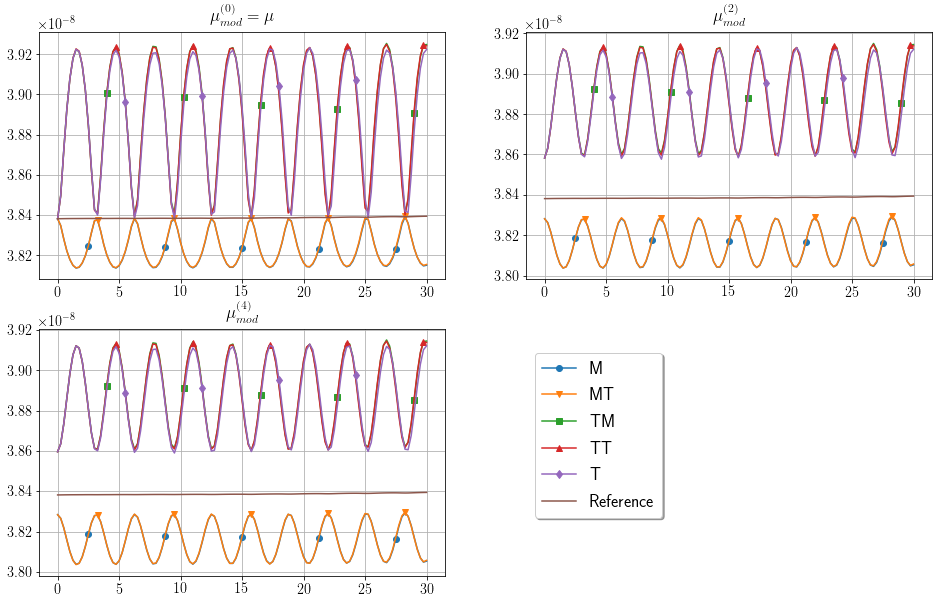

In [40]:
# Fig 5.4
compare_methods(initlist, tspan, h, ["M","MT","TM","TT","T","Reference"], potential=True, Ecorrection=False)

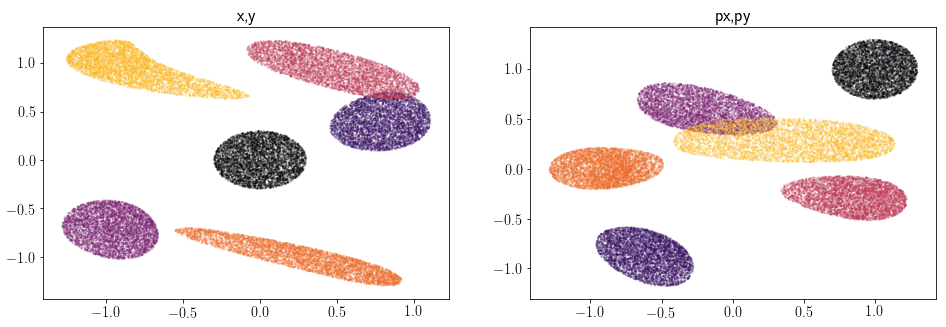

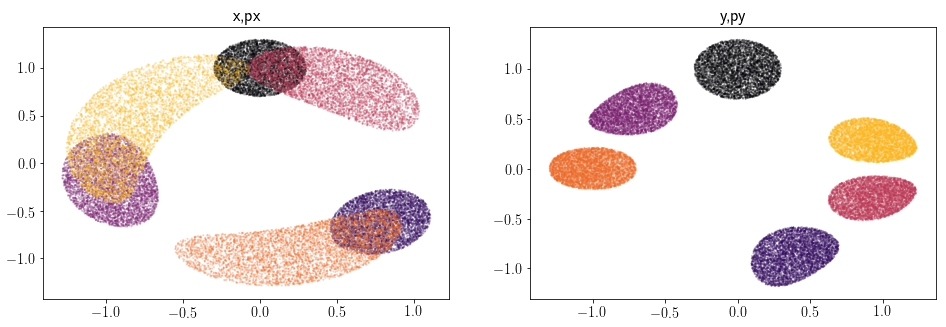

In [23]:
def show_point_cloud(cloudlist, period=4):
    cloudinterval = np.array(cloudlist[::period])
    
    plt.figure(figsize=(16,5))
    params = {"norm": clr.Normalize(vmin=0,vmax=1), "cmap": "inferno", "linewidths": 0, "s":2*1e4/len(initlist), "alpha": .3}
    
    plt.subplot(121)
    plt.title("x,y")
    k=0
    for cloud in cloudinterval:
        color = [k for i in range(len(cloud))]        
        plt.scatter(cloud[:,1], cloud[:,3], c = color, **params)
        k += 1/len(cloudinterval)
    
    plt.subplot(122)
    plt.title("px,py")
    k = 0
    for cloud in cloudinterval:
        color = [k for i in range(len(cloud))]
        plt.scatter(cloud[:,0], cloud[:,2], c = color, **params)
        k += 1/len(cloudinterval)
    
    plt.show()
    plt.figure(figsize=(16,5))
    
    plt.subplot(121)
    plt.title("x,px")
    k=0
    for cloud in cloudinterval:
        color = [k for i in range(len(cloud))]
        plt.scatter(cloud[:,1], cloud[:,0], c = color, **params)
        k += 1/len(cloudinterval)
    
    plt.subplot(122)
    plt.title("y,py")
    k = 0
    for cloud in cloudinterval:
        color = [k for i in range(len(cloud))]
        plt.scatter(cloud[:,3], cloud[:,2], c = color, **params)
        k += 1/len(cloudinterval)
    
    plt.show()
    
center = [1,0,1,0]
r = .3
initlist = []
for i in range(5000):
    v = np.random.normal(size=4)
    initlist += [ np.add(center, r/np.linalg.norm(v) * v) ]

h = .25
tspan = (0.0, 14.0)

cloudlist = simulate_point_cloud(initlist, tspan, h, method="Reference", potential=True)
show_point_cloud(cloudlist, period=11)